In [290]:
import os
import glob
import yaml  # You'll need to install the PyYAML library for YAML parsing
from cloudmesh.common.FlatDict import FlatDict
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Define the directory where you want to start the search
start_directory = 'project/'

# Initialize an empty dictionary to store the results
result = []

# Use a recursive search to find all files matching the pattern
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if file.startswith('result') and file.endswith('.out'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                csv_lines = [line.strip() for line in lines if line.startswith("# csv")]
                try:
                    result_line = [line.replace(":::MLLOG", "").strip() for line in lines if line.startswith(":::MLLOG") and '"result"' in line][0]
                    result_line = eval(result_line)
                    
                    for k in ['event_type', 'key', 'metadata', 'namespace', 'time_ms']:
                        del result_line[k]
                    
                except:
                    result_line = None
                csv_dict = {}
                for line in csv_lines[1:]:  # Skip the header line
                    line_parts = line.split(',')
                    timer_key = line_parts[1]
                    csv_dict[timer_key] = float(line_parts[3])
            
                if csv_lines:
                    config_path = os.path.join(root, 'config.yaml')
                    config = FlatDict()
                    try:
                        config.loadf(filename=config_path)
                    except:
                        config = None
                    # filter only the "experiment." values

                    filtered = {key.replace("experiment.",""): value 
                                for key, value in dict(config).items() if key.startswith('experiment.')}
                    entry = {
                        'name': file
                    }
                    entry.update(csv_dict)
                    entry.update(filtered)
                    entry.update({"result": result_line})
                    result.append(entry)


# Print the dictionary with the results, including the config
# for filename, data in result_dict.items():
#     print(f'File: {filename}')
#     print('CSV Lines:')
#     for line in data['csv_lines']:
#         print(line)
#    print('Config:')
#    for key, value in data['config'].items():
#        print(f'{key}: {value}')

#pprint(result_dict)

In [291]:
pprint(result[0])

result_data = result.copy()


{'batch_size': 32,
 'card_name': 'v100',
 'clip_offset': 15,
 'cpu_num': 1,
 'directive': 'v100',
 'early_stoppage': 'False',
 'early_stoppage_patience': '25',
 'epoch': '70',
 'gpu': 1,
 'gpu_count': '1',
 'inference': 144.679,
 'learning_rate': 0.001,
 'loaddata': 4.118,
 'mem': '64GB',
 'name': 'result-thf2bn-53854471.out',
 'no_cache': False,
 'nodes': 1,
 'repeat': '5',
 'result': {'value': {'inference': {'accuracy': [0.9233438888888889,
                                                 0.9345094444444444,
                                                 0.8940772222222222,
                                                 0.9105144444444444,
                                                 0.8391288888888889,
                                                 0.95098,
                                                 0.8876861111111111,
                                                 0.7732322222222222,
                                                 0.8472777777777778,
            

In [292]:
df = pd.DataFrame(result)
print(df.columns)

for c in ['epoch', 'repeat']:
    df[c] = df[c].astype(int)
for c in ['total', 'training', 'loaddata', 'inference']:
    df[c] = df[c].astype(float)

df = df.drop(columns=['name', 'mem', 'gpu_count', 'cpu_num', 'seed', 'batch_size', 'clip_offset', 'no_cache', 'gpu', 'nodes', 'train_split', 'learning_rate', 'early_stoppage_patience', 'card_name', 'training_on_mutiple_GPU'])

df['name'] = df['directive'].astype(str) + ',' + df['epoch'].astype(str) + ',' + df['early_stoppage'].astype(str)
df = df[['name'] + [col for col in df.columns if col != 'name']]
df['name'] = df['name'].str.replace(',False', '')
df['name'] = df['name'].str.replace(',True', '.es')
df


Index(['name', 'total', 'training', 'loaddata', 'inference', 'directive',
       'gpu_count', 'cpu_num', 'mem', 'repeat', 'epoch', 'seed',
       'learning_rate', 'batch_size', 'train_split', 'clip_offset', 'no_cache',
       'nodes', 'gpu', 'early_stoppage_patience', 'early_stoppage',
       'card_name', 'result', 'training_on_mutiple_GPU'],
      dtype='object')


,name,total,training,loaddata,inference,directive,repeat,epoch,early_stoppage,result
0,"v100,70",10739.745,10590.600,4.118,144.679,v100,5,70,False,"{'value': {'name': 'cloudmask', 'training': {'..."
1,"v100,50",7699.156,7554.603,2.069,142.281,v100,10,50,False,"{'value': {'name': 'cloudmask', 'training': {'..."
2,"a100-dgx,1.es",535.028,388.821,3.531,142.250,a100-dgx,1,1,True,"{'value': {'name': 'cloudmask', 'training': {'..."
3,"a100-dgx,50",4778.885,4634.194,2.255,142.229,a100-dgx,9,50,False,"{'value': {'name': 'cloudmask', 'training': {'..."
4,"a100-dgx,10.es",1977.314,1830.763,4.133,142.208,a100-dgx,1,10,True,"{'value': {'name': 'cloudmask', 'training': {'..."
...,...,...,...,...,...,...,...,...,...,...
246,"a100-dgx,30",2887.280,2743.253,1.624,142.189,a100-dgx,10,30,False,"{'value': {'name': 'cloudmask', 'training': {'..."
247,"a100-dgx,1.es",833.915,688.616,2.752,142.329,a100-dgx,7,1,True,"{'value': {'name': 'cloudmask', 'training': {'..."
248,"a100-dgx,1.es",834.985,688.298,4.200,142.271,a100-dgx,2,1,True,"{'value': {'name': 'cloudmask', 'training': {'..."
249,"v100,2.es",1095.535,885.759,4.519,204.995,v100,3,2,True,"{'value': {'name': 'cloudmask', 'training': {'..."


In [293]:
def exctract(df, newkey='test_accuracy', key1='value', key2='inference', key3='accuracy', key4=None):
    def extract_accuracy(row):
        try:
            if key4 is None:
                return row[key1][key2][key3]
            else:
                return row[key1][key2][key3][key4]
        except KeyError:
            return None
    df[newkey] = df['result'].apply(extract_accuracy)
    return df 

df = exctract(df, 'test_accuraccy', 'value', 'inference', 'accuracy')

df = exctract(df, 'training_accuracy', 'value', 'training', 'history', 'accuracy')
df = exctract(df, 'training_loss', 'value', 'training', 'history', 'loss')
df = exctract(df, 'training_val_loss', 'value', 'training', 'history', 'val_loss')
df = exctract(df, 'training_val_accuracy', 'value', 'training', 'history', 'val_accuracy')

df.drop(columns=['result'], inplace=True)

df

,name,total,training,loaddata,inference,directive,repeat,epoch,early_stoppage,test_accuraccy,training_accuracy,training_loss,training_val_loss,training_val_accuracy
0,"v100,70",10739.745,10590.600,4.118,144.679,v100,5,70,False,"[0.9233438888888889, 0.9345094444444444, 0.894...","[0.7971559762954712, 0.8036167621612549, 0.806...","[0.43057680130004883, 0.3868241310119629, 0.37...","[0.45389050245285034, 0.43061962723731995, 0.4...","[0.7767935395240784, 0.775540292263031, 0.8011..."
1,"v100,50",7699.156,7554.603,2.069,142.281,v100,10,50,False,"[0.9291155555555556, 0.9380033333333333, 0.898...","[0.7956450581550598, 0.8075904846191406, 0.809...","[0.43207019567489624, 0.38780638575553894, 0.3...","[0.42624223232269287, 0.41857537627220154, 0.4...","[0.7897810339927673, 0.7826666235923767, 0.804..."
2,"a100-dgx,1.es",535.028,388.821,3.531,142.250,a100-dgx,1,1,True,"[0.8405255555555555, 0.8955255555555556, 0.756...",[0.7982280850410461],[0.43050408363342285],[0.44134214520454407],[0.790053129196167]
3,"a100-dgx,50",4778.885,4634.194,2.255,142.229,a100-dgx,9,50,False,"[0.9231161111111111, 0.9363366666666667, 0.891...","[0.7970626354217529, 0.8018134832382202, 0.811...","[0.4316985011100769, 0.3839612305164337, 0.379...","[0.43978235125541687, 0.4166964888572693, 0.40...","[0.7638941407203674, 0.7882956266403198, 0.795..."
4,"a100-dgx,10.es",1977.314,1830.763,4.133,142.208,a100-dgx,1,10,True,"[0.8404905555555555, 0.8955255555555556, 0.863...","[0.7978211641311646, 0.8081563115119934, 0.807...","[0.43532851338386536, 0.3899448812007904, 0.37...","[0.43984732031822205, 0.4294833242893219, 0.40...","[0.7841931581497192, 0.7839409708976746, 0.805..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,"a100-dgx,30",2887.280,2743.253,1.624,142.189,a100-dgx,10,30,False,"[0.9207388888888889, 0.9326577777777778, 0.887...","[0.7972752451896667, 0.8053504824638367, 0.813...","[0.43281811475753784, 0.384273886680603, 0.376...","[0.41926032304763794, 0.41953715682029724, 0.4...","[0.7918235063552856, 0.7832990288734436, 0.803..."
247,"a100-dgx,1.es",833.915,688.616,2.752,142.329,a100-dgx,7,1,True,"[0.8636683333333334, 0.9012555555555556, 0.683...",[0.7947033643722534],[0.43173059821128845],[0.43002286553382874],[0.7822243571281433]
248,"a100-dgx,1.es",834.985,688.298,4.200,142.271,a100-dgx,2,1,True,"[0.8741338888888889, 0.9135294444444444, 0.699...",[0.7955150604248047],[0.43002140522003174],[0.4398189187049866],[0.7810288667678833]
249,"v100,2.es",1095.535,885.759,4.519,204.995,v100,3,2,True,"[0.8509655555555555, 0.8973094444444445, 0.677...","[0.7970331311225891, 0.8069105744361877]","[0.4293251633644104, 0.38269615173339844]","[0.434813916683197, 0.4234074354171753]","[0.780085563659668, 0.7779294848442078]"


In [294]:
print (result[0]['result']['value']['inference'].keys())

dict_keys(['avg_accuracy', 'accuracy'])


In [295]:
print(df.head(2).values.tolist())


[['v100,70', 10739.745, 10590.6, 4.118, 144.679, 'v100', 5, 70, 'False', [0.9233438888888889, 0.9345094444444444, 0.8940772222222222, 0.9105144444444444, 0.8391288888888889, 0.95098, 0.8876861111111111, 0.7732322222222222, 0.8472777777777778, 0.9639461111111111, 0.9149733333333333, 0.8905033333333333, 0.6264644444444445, 0.9434594444444444, 0.9502511111111112, 0.8874255555555556, 0.9090383333333333, 0.783135, 0.8810644444444444, 0.8861566666666667, 0.9271861111111112, 0.7000683333333333, 0.9493627777777778, 0.8812888888888889, 0.7280755555555556, 0.9413794444444444, 0.6406661111111112, 0.9485711111111111, 0.8190166666666666, 0.8649538888888889, 0.9245216666666667, 0.5231455555555555, 0.8900266666666666, 0.9201622222222222, 0.8942827777777778, 0.9398694444444444, 0.9456305555555555, 0.8512122222222223, 0.9236327777777777, 0.9262188888888889, 0.8431988888888889, 0.7898244444444444, 0.9462755555555555, 0.9299205555555555, 0.9505644444444444, 0.8782683333333333, 0.8345605555555555, 0.93334

In [296]:
def save_plot_to_multiple_formats(plot, filename_without_extension):
    """
    Save a Matplotlib plot to multiple file formats.

    Args:
        plot (matplotlib.figure.Figure): The Matplotlib figure to save.
        filename_without_extension (str): The base filename without extension.

    Returns:
        None
    """
    # Save as SVG
    svg_filename = filename_without_extension + '.svg'
    plot.savefig(svg_filename, format='svg', bbox_inches='tight')

    # Save as JPG
    jpg_filename = filename_without_extension + '.jpg'
    plot.savefig(jpg_filename, format='jpg', bbox_inches='tight')

    # Save as PNG
    png_filename = filename_without_extension + '.png'
    plot.savefig(png_filename, format='png', bbox_inches='tight')

    # Save as PDF
    pdf_filename = filename_without_extension + '.pdf'
    plot.savefig(pdf_filename, format='pdf', bbox_inches='tight')


In [297]:
df

,name,total,training,loaddata,inference,directive,repeat,epoch,early_stoppage,test_accuraccy,training_accuracy,training_loss,training_val_loss,training_val_accuracy
0,"v100,70",10739.745,10590.600,4.118,144.679,v100,5,70,False,"[0.9233438888888889, 0.9345094444444444, 0.894...","[0.7971559762954712, 0.8036167621612549, 0.806...","[0.43057680130004883, 0.3868241310119629, 0.37...","[0.45389050245285034, 0.43061962723731995, 0.4...","[0.7767935395240784, 0.775540292263031, 0.8011..."
1,"v100,50",7699.156,7554.603,2.069,142.281,v100,10,50,False,"[0.9291155555555556, 0.9380033333333333, 0.898...","[0.7956450581550598, 0.8075904846191406, 0.809...","[0.43207019567489624, 0.38780638575553894, 0.3...","[0.42624223232269287, 0.41857537627220154, 0.4...","[0.7897810339927673, 0.7826666235923767, 0.804..."
2,"a100-dgx,1.es",535.028,388.821,3.531,142.250,a100-dgx,1,1,True,"[0.8405255555555555, 0.8955255555555556, 0.756...",[0.7982280850410461],[0.43050408363342285],[0.44134214520454407],[0.790053129196167]
3,"a100-dgx,50",4778.885,4634.194,2.255,142.229,a100-dgx,9,50,False,"[0.9231161111111111, 0.9363366666666667, 0.891...","[0.7970626354217529, 0.8018134832382202, 0.811...","[0.4316985011100769, 0.3839612305164337, 0.379...","[0.43978235125541687, 0.4166964888572693, 0.40...","[0.7638941407203674, 0.7882956266403198, 0.795..."
4,"a100-dgx,10.es",1977.314,1830.763,4.133,142.208,a100-dgx,1,10,True,"[0.8404905555555555, 0.8955255555555556, 0.863...","[0.7978211641311646, 0.8081563115119934, 0.807...","[0.43532851338386536, 0.3899448812007904, 0.37...","[0.43984732031822205, 0.4294833242893219, 0.40...","[0.7841931581497192, 0.7839409708976746, 0.805..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,"a100-dgx,30",2887.280,2743.253,1.624,142.189,a100-dgx,10,30,False,"[0.9207388888888889, 0.9326577777777778, 0.887...","[0.7972752451896667, 0.8053504824638367, 0.813...","[0.43281811475753784, 0.384273886680603, 0.376...","[0.41926032304763794, 0.41953715682029724, 0.4...","[0.7918235063552856, 0.7832990288734436, 0.803..."
247,"a100-dgx,1.es",833.915,688.616,2.752,142.329,a100-dgx,7,1,True,"[0.8636683333333334, 0.9012555555555556, 0.683...",[0.7947033643722534],[0.43173059821128845],[0.43002286553382874],[0.7822243571281433]
248,"a100-dgx,1.es",834.985,688.298,4.200,142.271,a100-dgx,2,1,True,"[0.8741338888888889, 0.9135294444444444, 0.699...",[0.7955150604248047],[0.43002140522003174],[0.4398189187049866],[0.7810288667678833]
249,"v100,2.es",1095.535,885.759,4.519,204.995,v100,3,2,True,"[0.8509655555555555, 0.8973094444444445, 0.677...","[0.7970331311225891, 0.8069105744361877]","[0.4293251633644104, 0.38269615173339844]","[0.434813916683197, 0.4234074354171753]","[0.780085563659668, 0.7779294848442078]"


In [298]:

es_false_df = df[df['early_stoppage'] == 'False'].copy()
es_true_df = df[df['early_stoppage'] == 'True'].copy()


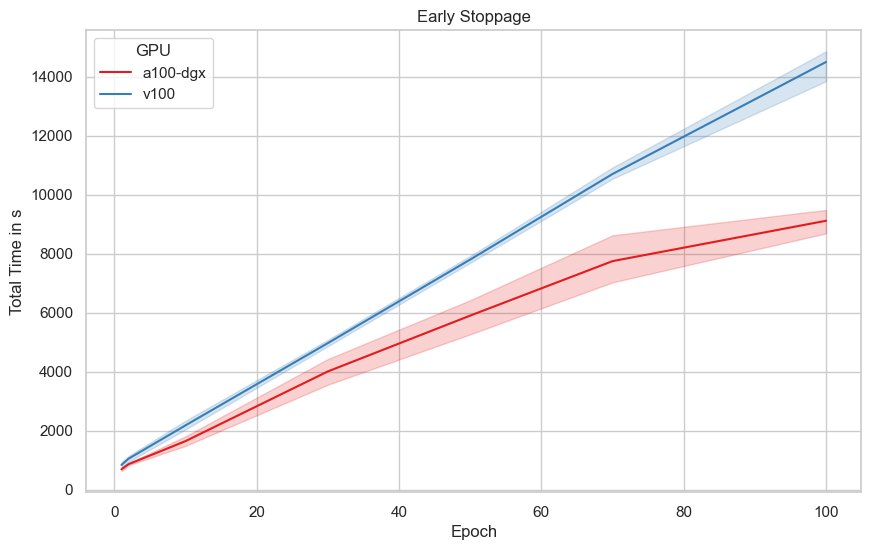

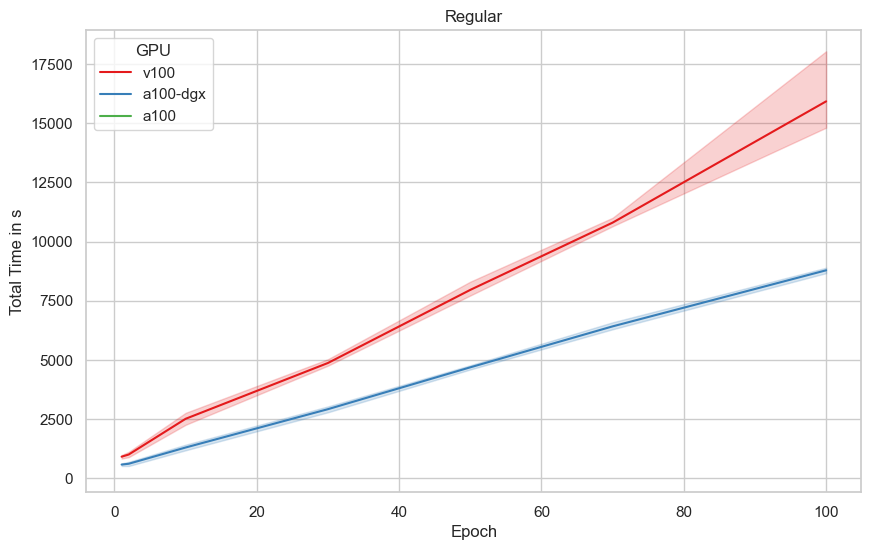

In [299]:

def create_line_plot(df, title):
    plt.figure(figsize=(10, 6))  # Optional: Set the figure size
    plot = sns.lineplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')
    plt.xlabel('Epoch')
    plt.ylabel('Total Time in s')
    legend = plt.legend(title='Directive')
    legend.set_title('GPU')
    plt.title(title)
    plt.show()


create_line_plot(es_true_df, "Early Stoppage")
create_line_plot(es_false_df, "Regular")

/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: v100
t(epoch, v100) = 705.00 + 148.65 * epoch


/home/green/ENV3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Derived Formula: a100-dgx
t(epoch, a100-dgx) = 470.51 + 83.76 * epoch


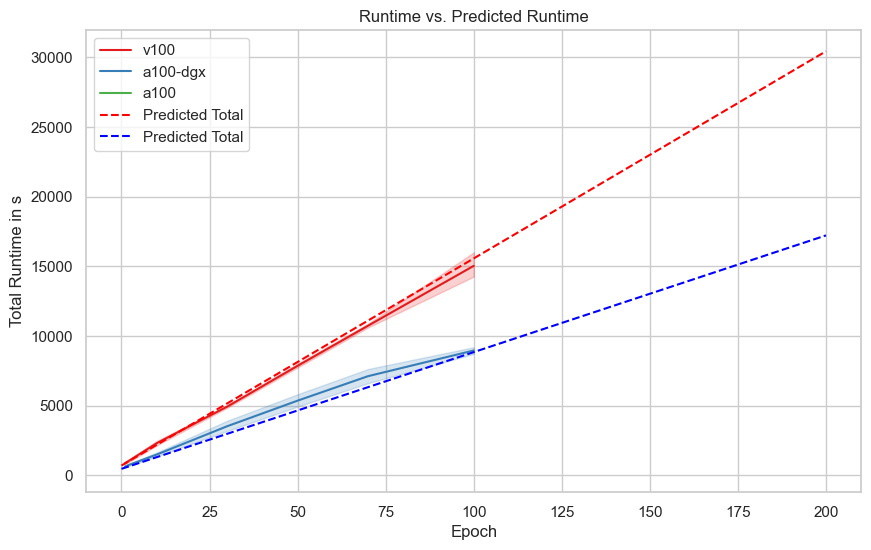

In [300]:

plt.figure(figsize=(10, 6))
plot = sns.lineplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')
plt.xlabel('Epoch')
plt.ylabel('Total Runtime in s')

color = {
    'v100': 'red',
    'a100-dgx': 'blue'
}
for directive in ['v100', 'a100-dgx']:
    data = df[(df['directive'] == directive) & (df['early_stoppage'] == 'False')]
    # data = df[df['directive'] == directive]
    data = data[['epoch', 'total']]
    
    X = data[['epoch']]
    y = data['total']
    
    # Create and train a linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Generate predicted values for a range of epochs (0 to 200)
    epochs_to_predict = np.arange(0, 201).reshape(-1, 1)
    predicted_total = model.predict(epochs_to_predict)
    
    # Plot the original 'total' values and the predicted values
    intercept = model.intercept_
    slope = model.coef_[0]
    
    # Create the formula
    formula = f"t(epoch, {directive}) = {intercept:.2f} + {slope:.2f} * epoch"
    
    print("Derived Formula:", directive)
    print(formula)
    plt.plot(epochs_to_predict, predicted_total, marker='', linestyle='--', color=color[directive], label='Predicted Total')

plt.title('Runtime vs. Predicted Runtime')
plt.legend()
plt.grid(True)
plt.show()


In [301]:
import humanize

epoch = 200
t = 470.51 + 83.76 * epoch
t = humanize.precisedelta(t, minimum_unit='hours')
print("a100", t)


epoch = 200
t = 705.00 + 148.65 * epoch
t = humanize.precisedelta(t, minimum_unit='hours')
print("v100", t)


a100 4.78 hours
v100 8.45 hours


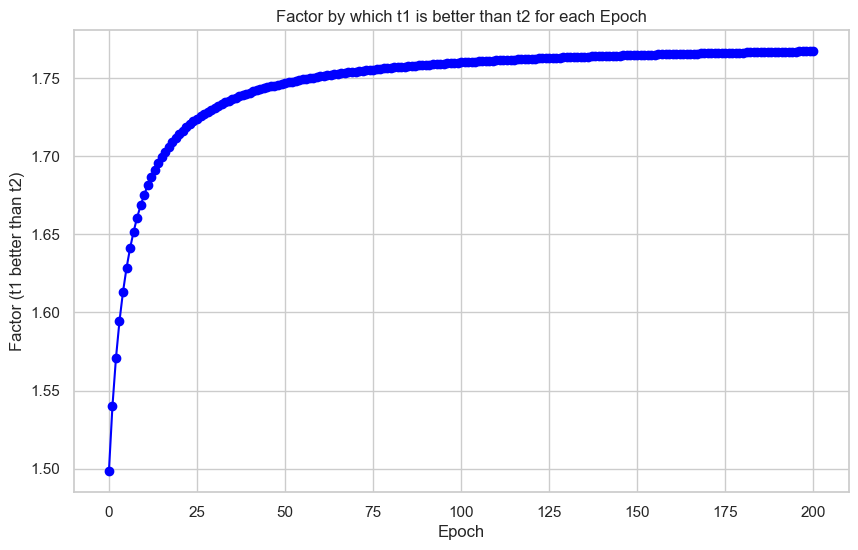

Overall 1.77


In [302]:
epoch_values = np.arange(0, 201)

# Initialize an empty list to store the factors
factors = []

# Calculate the factors for each 'epoch' value
for epoch_value in epoch_values:
    t1_value = 705.00 + 148.65 * epoch_value
    t2_value = 470.51 + 83.76 * epoch_value
    factor = t1_value / t2_value
    factors.append(factor)

# Create a line plot of the factors
plt.figure(figsize=(10, 6))
plt.plot(epoch_values, factors, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Factor (t1 better than t2)')
plt.title('Factor by which t1 is better than t2 for each Epoch')
plt.grid(True)
plt.show()

epoch_value = 200
t1_value = 705.00 + 148.65 * epoch_value
t2_value = 470.51 + 83.76 * epoch_value
factor = t1_value / t2_value
    
print ("Overall", round(factor,2))

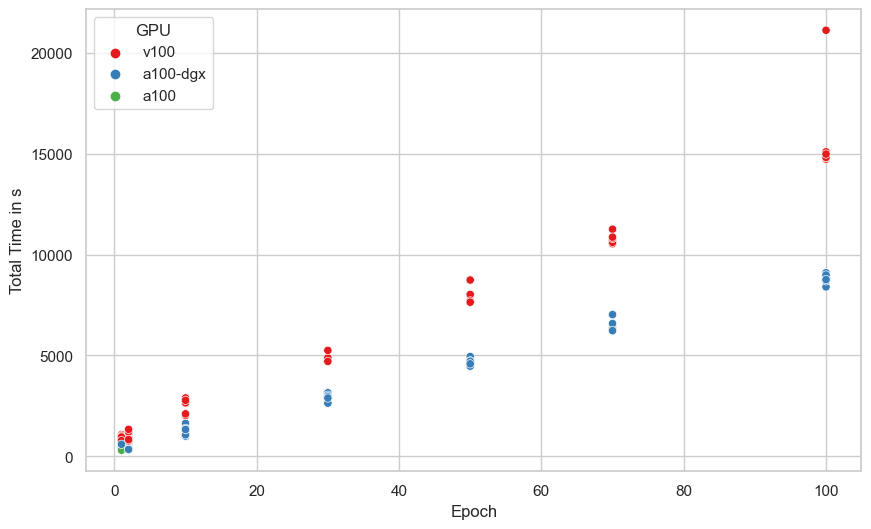

In [303]:
df = es_false_df
# Set the style of the plot
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.scatterplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')
plt.legend(title='GPU')

# Show the plot
plt.show()



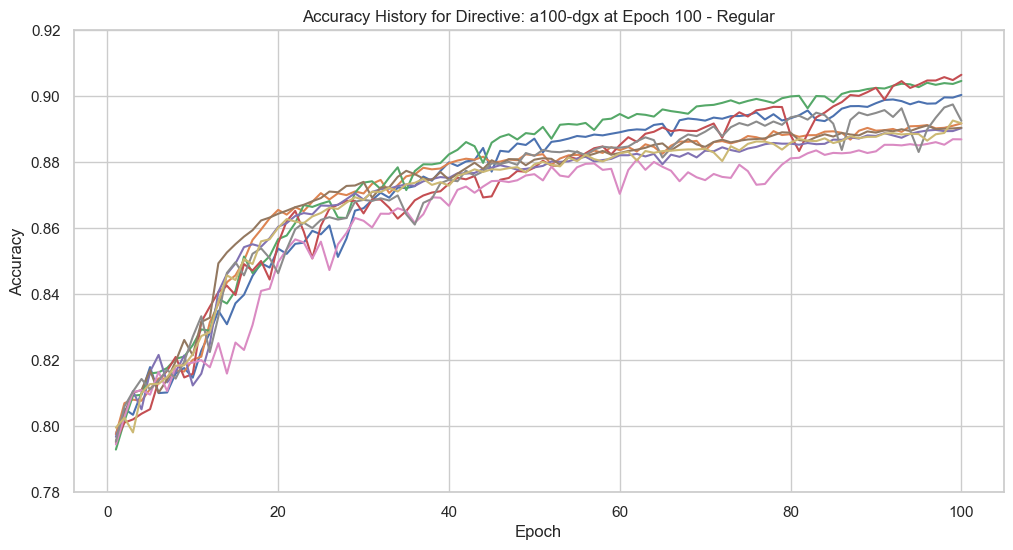

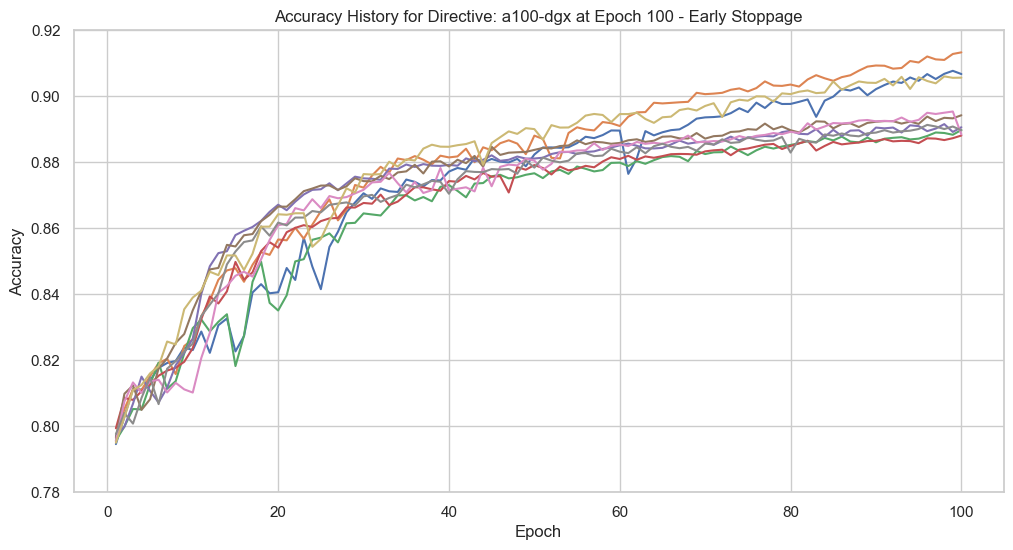

In [304]:
def plot_accuracy_history_for_directive(df, selected_directive, selected_epoch, title):
    # Filter rows with valid directive names
    df = df[df['directive'].notna()]

    # Filter the DataFrame for the selected directive and epoch
    filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

    # Create an empty list to store accuracy histories
    accuracy_histories = []

    # Iterate through the filtered DataFrame and extract accuracy histories
    for index, row in filtered_df.iterrows():
        accuracy_history = row['training_accuracy']
        accuracy_histories.append(accuracy_history[:selected_epoch])

    # Create a Seaborn line plot for all matching directives
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    for idx, accuracy_history in enumerate(accuracy_histories):
        sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)
        # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch} - {title}')
    # plt.legend(title='Results')
    plt.ylim(0.78, 0.92)
    plt.show()

selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 100

plot_accuracy_history_for_directive(es_false_df, selected_directive, selected_epoch, "Regular")
plot_accuracy_history_for_directive(es_true_df, selected_directive, selected_epoch, "Early Stoppage")

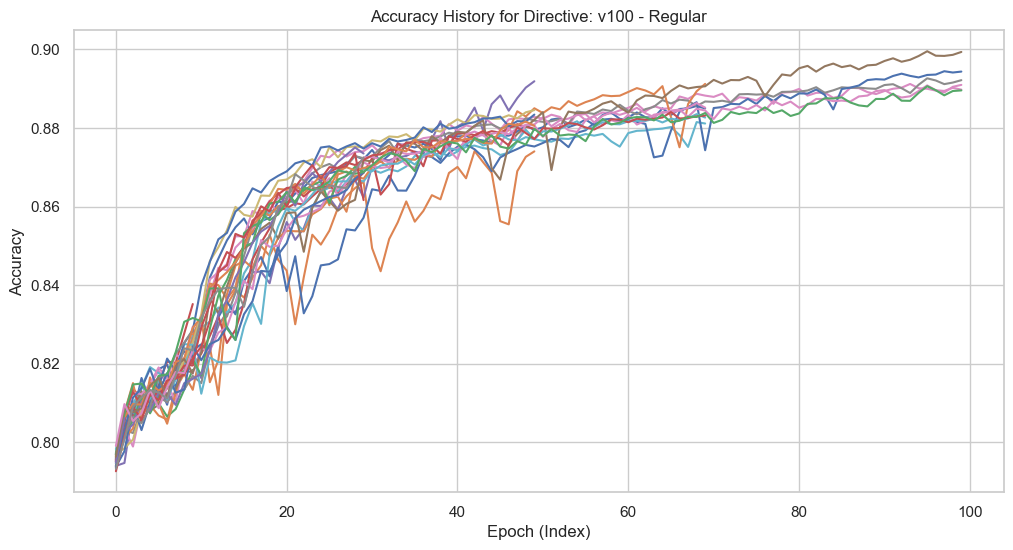

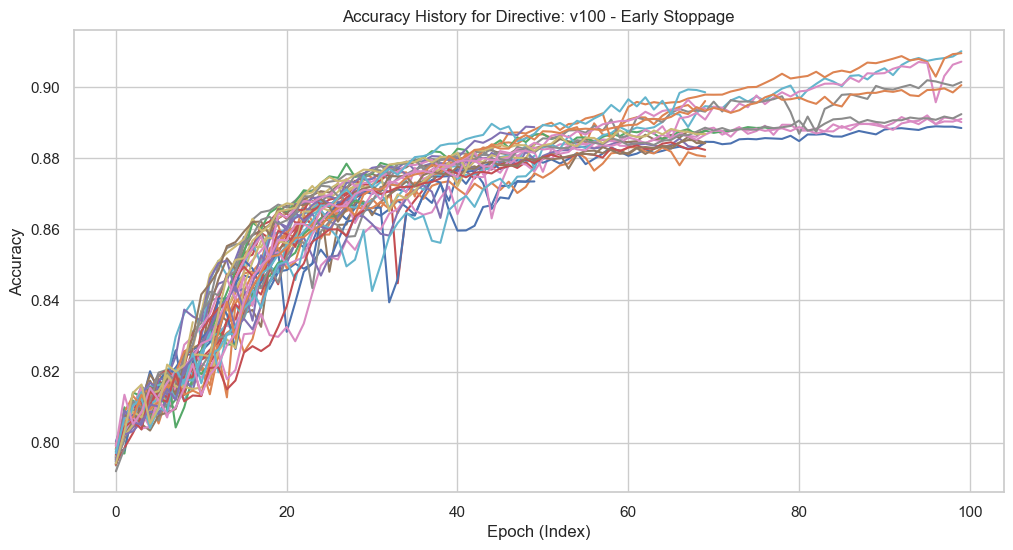

In [305]:


def plot_accuracy_history(df, title):
    # Filter rows with valid directive names
    df = df[df['directive'].notna()]

    # Specify the directive you want to plot
    selected_directive = 'v100'  # Replace with your desired directive

    # Filter the DataFrame for the selected directive
    directive_df = df[df['directive'] == selected_directive]

    # Extract all accuracy histories for the selected directive
    accuracy_histories = directive_df['training_accuracy'].apply(lambda x: x)

    # Create a Seaborn line plot for all accuracy histories
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    for idx, accuracy_history in enumerate(accuracy_histories):
        x_values = list(range(len(accuracy_history)))
        # sns.lineplot(x=x_values, y=accuracy_history, label=f'Result {idx + 1}')
        sns.lineplot(x=x_values, y=accuracy_history)

    plt.xlabel('Epoch (Index)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy History for Directive: {selected_directive} - {title}')
    # plt.legend(title='Results')
    plt.show()
    
plot_accuracy_history(es_false_df, "Regular")
plot_accuracy_history(es_true_df, "Early Stoppage")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


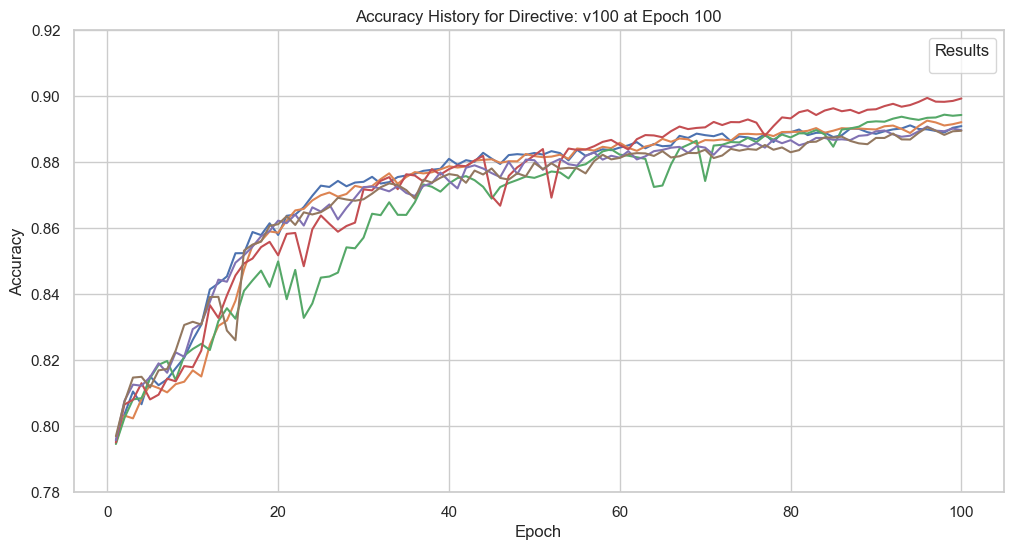

In [306]:


# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'v100'  # Replace with your desired directive
selected_epoch = 100

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    accuracy_history = row['training_accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.ylim(0.78, 0.92)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


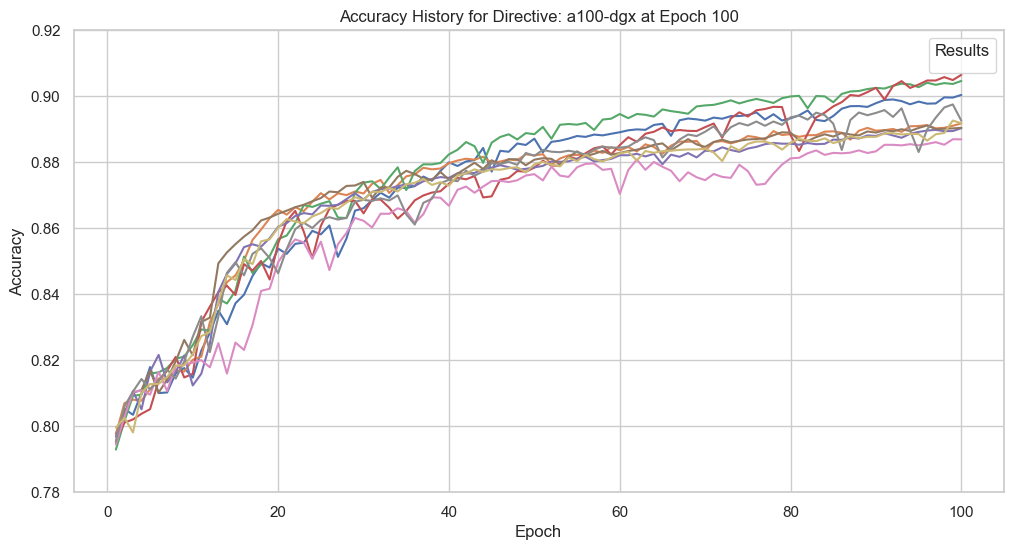

In [307]:
df = df[df['directive'].notna()]

# Specify the directive you want to select
selected_directive = 'a100-dgx'  # Replace with your desired directive
selected_epoch = 100

# Filter the DataFrame for the selected directive and epoch
filtered_df = df[(df['directive'] == selected_directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]

# Create an empty list to store accuracy histories
accuracy_histories = []

# Iterate through the filtered DataFrame and extract accuracy histories
for index, row in filtered_df.iterrows():
    accuracy_history = row['training_accuracy']
    accuracy_histories.append(accuracy_history[:selected_epoch])

# Create a Seaborn line plot for all matching directives
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

for idx, accuracy_history in enumerate(accuracy_histories):
    # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'Result {idx + 1}')
    sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directive: {selected_directive} at Epoch {selected_epoch}')
plt.legend(title='Results')
plt.ylim(0.78, 0.92)
plt.show()

In [308]:
def plot_history(data, epoch=100, directives=["a100-dgx","v100"], value="training_accuracy"):
    df = data[data['directive'].notna()].copy()
    
    # Specify the list of directives you want to select
    selected_directives = directives # ['a100-dgx', 'v100']  # Replace with your desired directives
    selected_epoch = epoch
    
    # Create an empty list to store accuracy histories for each directive
    accuracy_histories_dict = {directive: [] for directive in selected_directives}
    
    
    
    # Iterate through the DataFrame and extract accuracy histories for selected directives
    for directive in selected_directives:
        filtered_df = df[(df['directive'] == directive) & (df[value].apply(lambda x: len(x)) >= selected_epoch)]
        
        for index, row in filtered_df.iterrows():
            accuracy_history = row[value]
            accuracy_histories_dict[directive].append(accuracy_history[:selected_epoch])
    
    # Create Seaborn line plots for each directive with a legend
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    for directive, accuracy_histories in accuracy_histories_dict.items():
        for idx, accuracy_history in enumerate(accuracy_histories):
            #sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1}')
            sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)
    
    plt.xlabel('Epoch')
    plt.ylabel(value.capitalize())
    plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
    plt.legend()
    #plt.ylim(0.78, 0.92)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


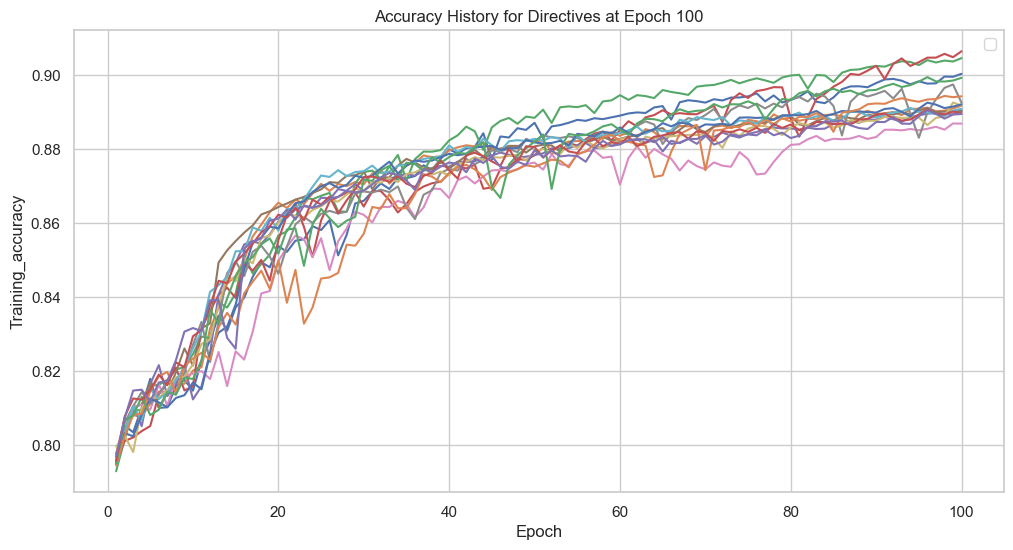

In [309]:


value = 'accuracy'
# Filter rows with valid directive names
df = df[df['directive'].notna()]

plot_history(df, directives=['a100-dgx', 'v100'], epoch=100, value="training_accuracy")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


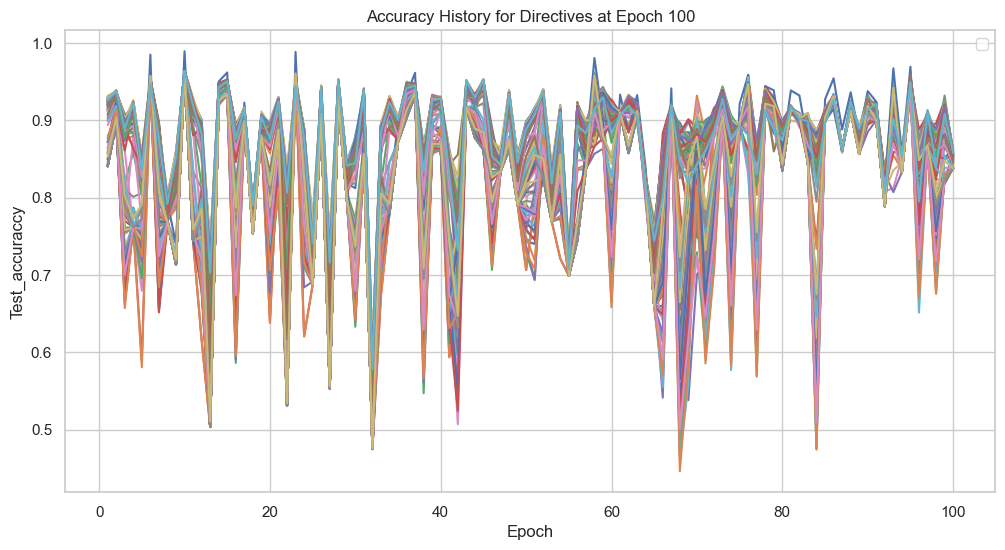

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


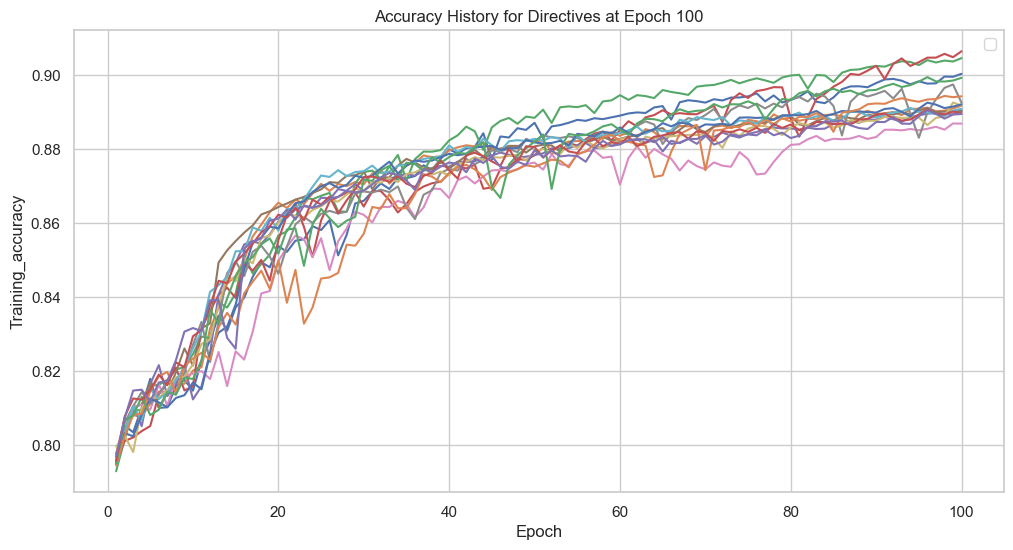

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


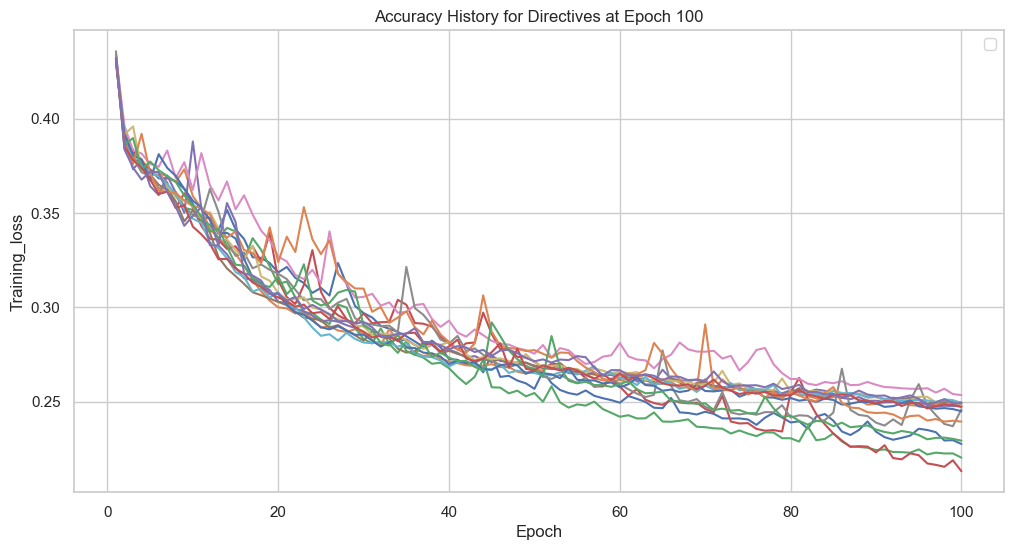

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


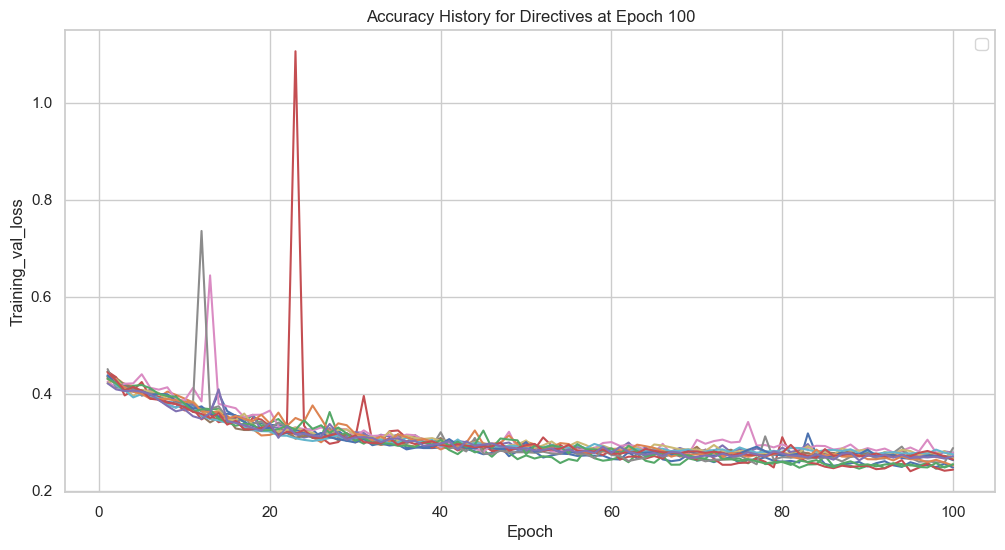

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


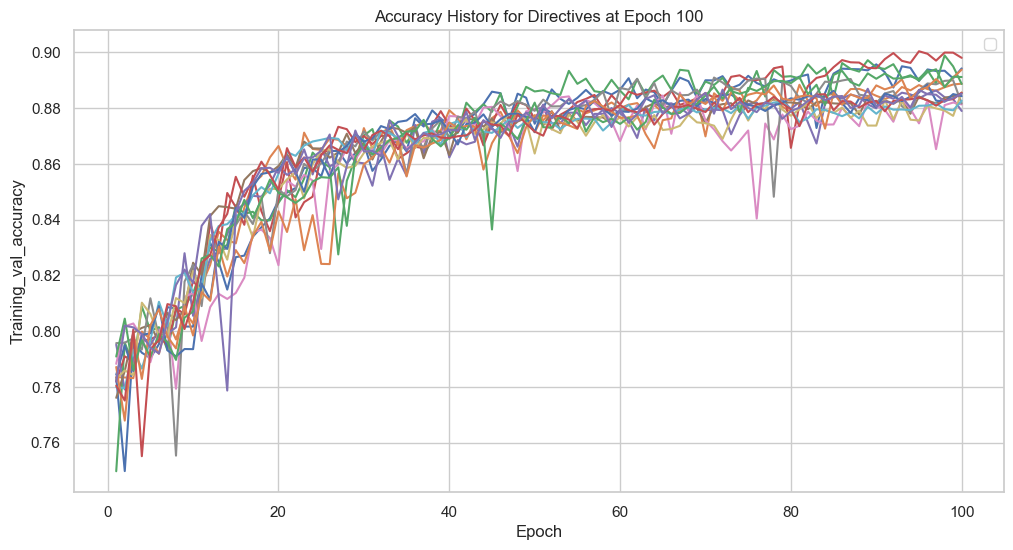

In [310]:
for k in ['test_accuraccy', 'training_accuracy',
       'training_loss', 'training_val_loss', 'training_val_accuracy']:
    plot_history(df, directives=['a100-dgx', 'v100'], epoch=100, value=k)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


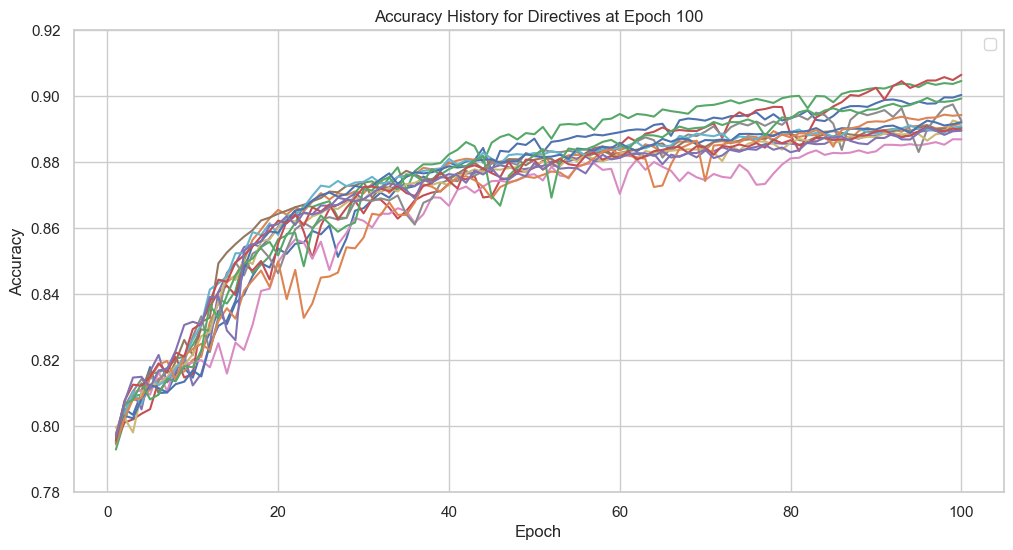

In [311]:

# Filter rows with valid directive names
df = df[df['directive'].notna()]

# Specify the list of directives you want to select
selected_directives = ['a100-dgx', 'v100']  # Replace with your desired directives
selected_epoch = 100

# Create a dictionary to store accuracy histories and best accuracies for each directive
directive_data = {}

# Iterate through the DataFrame and extract accuracy histories for selected directives
for directive in selected_directives:
    filtered_df = df[(df['directive'] == directive) & (df['training_accuracy'].apply(lambda x: len(x)) >= selected_epoch)]
    
    directive_accuracies = []
    
    for index, row in filtered_df.iterrows():
        
        accuracy_history = row["training_accuracy"]
        directive_accuracies.append(accuracy_history[:selected_epoch])
    
    # Calculate the best accuracy for this directive
    best_accuracy = max([accuracy[-1] for accuracy in directive_accuracies])
    
    directive_data[directive] = {
        'accuracies': directive_accuracies,
        'best_accuracy': best_accuracy
    }

# Sort directives by best accuracy in descending order
sorted_directives = sorted(directive_data.keys(), key=lambda x: directive_data[x]['best_accuracy'], reverse=True)

# Create Seaborn line plots for each directive with a legend
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

for directive in sorted_directives:
    for idx, accuracy_history in enumerate(directive_data[directive]['accuracies']):
        best_accuracy = directive_data[directive]['best_accuracy']
        # sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history, label=f'{directive} - Result {idx + 1} (Best: {best_accuracy:.4f})')
        sns.lineplot(x=range(1, selected_epoch + 1), y=accuracy_history)

        
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy History for Directives at Epoch {selected_epoch}')
plt.legend()
plt.ylim(0.78, 0.92)
plt.show()


In [312]:
print(result_data[0])

{'name': 'result-thf2bn-53854471.out', 'total': 10739.745, 'training': 10590.6, 'loaddata': 4.118, 'inference': 144.679, 'directive': 'v100', 'gpu_count': '1', 'cpu_num': 1, 'mem': '64GB', 'repeat': '5', 'epoch': '70', 'seed': 1234, 'learning_rate': 0.001, 'batch_size': 32, 'train_split': 0.8, 'clip_offset': 15, 'no_cache': False, 'nodes': 1, 'gpu': 1, 'early_stoppage_patience': '25', 'early_stoppage': 'False', 'card_name': 'v100', 'result': {'value': {'name': 'cloudmask', 'training': {'samples': 970, 'accuracy': 0.8849480152130127, 'loss': 0.2601945102214813, 'val_loss': 0.2793876826763153, 'val_accuracy': 0.8799592852592468, 'history': {'accuracy': [0.7971559762954712, 0.8036167621612549, 0.8068755269050598, 0.8164012432098389, 0.8104918003082275, 0.8150579929351807, 0.809596598148346, 0.8198840618133545, 0.8231695294380188, 0.8217014074325562, 0.8314782977104187, 0.8419565558433533, 0.8467669486999512, 0.851389467716217, 0.8547239303588867, 0.8569662570953369, 0.8529560565948486, 0.

In [313]:
accuracy_list = []
loss_list = []
val_accuracy_list = []
val_loss_list = []

# Iterate through the list of dictionaries and extract the values
for entry in result_data:
    accuracy_list.extend(entry['result']['value']['inference']['accuracy'])
    loss_list.extend(entry['result']['value']['training']['history']['loss'])
    val_accuracy_list.extend(entry['result']['value']['training']['history']['val_accuracy'])
    val_loss_list.extend(entry['result']['value']['training']['history']['val_loss'])
    
print ("OOOO")
print (len(accuracy_list))
print (len(loss_list))
print (len(val_accuracy_list))
print (len(val_loss_list))

# Create a DataFrame with the extracted values
df = pd.DataFrame({
#    'Accuracy': accuracy_list,
    'Loss': loss_list,
    'Val_Accuracy': val_accuracy_list,
    'Val_Loss': val_loss_list
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

OOOO
25100
9092
9092
9092


,Loss,Val_Accuracy,Val_Loss,Index
0,0.430577,0.776794,0.453891,1
1,0.386824,0.775540,0.430620,2
2,0.376532,0.801155,0.401342,3
3,0.371918,0.795250,0.420809,4
4,0.372598,0.803972,0.395189,5
...,...,...,...,...
9087,0.431731,0.782224,0.430023,9088
9088,0.430021,0.781029,0.439819,9089
9089,0.429325,0.780086,0.434814,9090
9090,0.382696,0.777929,0.423407,9091


In [314]:
print(df.head)


<bound method NDFrame.head of           Loss  Val_Accuracy  Val_Loss  Index
0     0.430577      0.776794  0.453891      1
1     0.386824      0.775540  0.430620      2
2     0.376532      0.801155  0.401342      3
3     0.371918      0.795250  0.420809      4
4     0.372598      0.803972  0.395189      5
...        ...           ...       ...    ...
9087  0.431731      0.782224  0.430023   9088
9088  0.430021      0.781029  0.439819   9089
9089  0.429325      0.780086  0.434814   9090
9090  0.382696      0.777929  0.423407   9091
9091  0.429758      0.771661  0.435519   9092

[9092 rows x 4 columns]>


In [315]:
n = 10
sorted_loss_df = df.sort_values(by='Loss', ascending=True)
sorted_loss_df.head(n)


,Loss,Val_Accuracy,Val_Loss,Index
2679,0.199810,0.897785,0.241412,2680
2680,0.200264,0.901221,0.246489,2681
2676,0.201790,0.897645,0.245667,2677
2677,0.202661,0.903705,0.231952,2678
2678,0.204341,0.900311,0.233932,2679
2674,0.205270,0.902601,0.236343,2675
5019,0.206996,0.900335,0.234551,5020
2673,0.207253,0.906095,0.229660,2674
5018,0.207319,0.901742,0.231108,5019
2675,0.207439,0.902332,0.239733,2676


In [316]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Accuracy', ascending=False)
sorted_loss_df.head(n)

,Loss,Val_Accuracy,Val_Loss,Index
2673,0.207253,0.906095,0.229660,2674
2677,0.202661,0.903705,0.231952,2678
2667,0.214195,0.903322,0.230953,2668
5012,0.211255,0.902921,0.230630,5013
5479,0.214600,0.902743,0.229643,5480
5008,0.215043,0.902696,0.234546,5009
2674,0.205270,0.902601,0.236343,2675
2675,0.207439,0.902332,0.239733,2676
5476,0.215777,0.902097,0.245385,5477
5010,0.213458,0.902078,0.236453,5011


In [317]:
n = 10
sorted_loss_df = df.sort_values(by='Val_Loss', ascending=True)
sorted_loss_df.head(n)

,Loss,Val_Accuracy,Val_Loss,Index
5479,0.214600,0.902743,0.229643,5480
2673,0.207253,0.906095,0.229660,2674
5012,0.211255,0.902921,0.230630,5013
2667,0.214195,0.903322,0.230953,2668
5018,0.207319,0.901742,0.231108,5019
2677,0.202661,0.903705,0.231952,2678
5011,0.210702,0.900991,0.233457,5012
4783,0.211151,0.899432,0.233491,4784
2672,0.208772,0.900971,0.233717,2673
2678,0.204341,0.900311,0.233932,2679


In [318]:
df = pd.DataFrame({
    'Accuracy': accuracy_list,
})
df['Index'] = range(1, len(df) + 1)
# Display the DataFrame
df

,Accuracy,Index
0,0.923344,1
1,0.934509,2
2,0.894077,3
3,0.910514,4
4,0.839129,5
...,...,...
25095,0.751298,25096
25096,0.867493,25097
25097,0.718101,25098
25098,0.826334,25099


In [319]:
n = 10
sorted_accuracy_loss = df.sort_values(by='Accuracy', ascending=False)
sorted_accuracy_loss.head(n)


,Accuracy,Index
6509,0.989144,6510
6522,0.988317,6523
5309,0.986433,5310
5322,0.985733,5323
6505,0.984737,6506
5357,0.982523,5358
5305,0.981844,5306
6557,0.980435,6558
11909,0.979663,11910
11922,0.977586,11923
